# Model Review

## Created By: David Hatchett
## Created: 2026-02-10

this is doign the test loop to verify how good the model is working. Also we are creating graphs for the paper.

In [ ]:
import board_game_rec as bgr 
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import json

import torchmetrics

from torch.utils.data import DataLoader



from matplotlib import pyplot as plt 

In [ ]:
### set up the device for the model. I got this from a search to the best way to set this up.

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): 
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
## load the data from the json file
## this way we can create graphs on the training results.
rslt_hist = pd.DataFrame(json.load(open('model/history.json','r',encoding='utf-8')))

In [8]:
rslt_hist

,train_loss,validation_loss,train_precision,train_recall,validation_precision,validation_recall
0,1.985130,1.600181,0.827635,0.679188,0.854100,0.735852
1,1.602645,1.565099,0.851447,0.744874,0.850381,0.759974
2,1.573078,1.561905,0.852561,0.752192,0.855642,0.746848
3,1.564320,1.555251,0.853334,0.753215,0.855056,0.745962
4,1.560643,1.547214,0.853608,0.753873,0.853756,0.757043
5,1.559070,1.544575,0.853811,0.753456,0.853068,0.758601
6,1.557875,1.557743,0.853839,0.753857,0.857718,0.742727
7,1.555966,1.545316,0.853995,0.754116,0.853481,0.757913
8,1.554839,1.551126,0.854166,0.754223,0.863645,0.720899
9,1.554318,1.543110,0.854207,0.753854,0.855196,0.753975


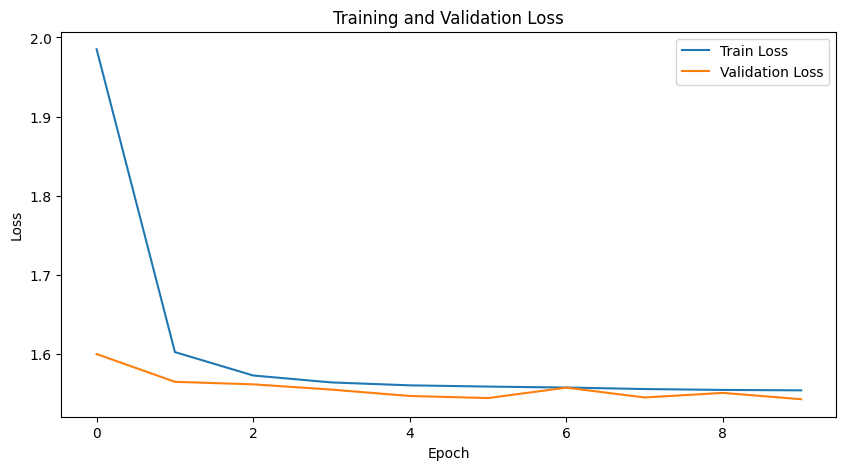

In [73]:
## creae a graph of the training and validation loss
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(rslt_hist['train_loss'], label='Train Loss')
ax.plot(rslt_hist['validation_loss'], label='Validation Loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
plt.show()




In [ ]:
### test the model on the test set
df = pd.read_csv('data/prep_data/test_data.csv')
df['category_indices'] = df['category_indices'].apply(ast.literal_eval)
df['mechanic_indices'] = df['mechanic_indices'].apply(ast.literal_eval)

test_dataset = bgr.UserGameDataSet(df)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=0, collate_fn=bgr.collate_fn)

In [ ]:
#Get rid of extra data
del (df,test_dataset)

In [ ]:
config = bgr.setup_config("config/config.json")
user_encoder, game_encoder, category_encoder, mechanic_encoder = bgr.get_encoders(config)


### set up the model
model = bgr.BoardGameRecommender(
    num_users=len(user_encoder),
    num_games=len(game_encoder),
    num_categories=len(category_encoder),
    num_mechanics=len(mechanic_encoder),
    dropout_rate=0.2,
)

model.load_state_dict(torch.load('model/board_game_recommender10.pt'))

<All keys matched successfully>

In [ ]:
### set loop for test


nrmse_list = []
mae_list = []
r2_list = []


model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        x = model(
                    user_id = batch["users_id"],
                    game_id = batch["game_id"],
                    avg_usr_rating = batch["avg_usr_rating"],
                    avg_usr_weight = batch["avg_usr_weight"],
                    bayes_average = batch["bayes_average"],
                    age = batch["age"],
                    game_owners = batch["game_owners"],
                    category_indices = batch["category_indices"],
                    category_offsets = batch["category_offsets"],
                    mechanic_indices = batch["mechanic_indices"],
                    mechanic_offsets = batch["mechanic_offsets"],
        ).to(device)
        out_true = batch['user_rating'].to(torch.float32)
        out_pred = x.squeeze()

        nrmse_list.append(torchmetrics.functional.regression.normalized_root_mean_squared_error(out_pred, out_true, normalization='range',num_outputs=1).cpu())
        mae_list.append(torchmetrics.functional.mean_absolute_error(out_pred, out_true).cpu())
        r2_list.append(torchmetrics.functional.r2_score(out_pred, out_true).cpu())



In [ ]:
#Get the results test loop.
print(f'nrmse mean: {np.mean(nrmse_list)}')
print(f'nrmse max: {np.max(nrmse_list)}')
print(f'nrmse min: {np.min(nrmse_list)}')
print(f'mae mean: {np.mean(mae_list)}')
print(f'mae max: {np.max(mae_list)}')
print(f'mae min: {np.min(mae_list)}')
print(f'r2 mean: {np.mean(r2_list)}')
print(f'r2 max: {np.max(r2_list)}')
print(f'r2 min: {np.min(r2_list)}')

nrmse mean: 0.1380763053894043
nrmse max: 0.15692709386348724
nrmse min: 0.12218758463859558
mae mean: 0.9164406061172485
mae max: 1.0283126831054688
mae min: 0.8359184265136719
r2 mean: 0.38210219144821167
r2 max: 0.49073272943496704
r2 min: 0.27295219898223877
